In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, SpatialDropout2D, BatchNormalization, Input,Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model,save_model

In [2]:
path  = "../input/face-mask-12k-images-dataset/Face Mask Dataset/"

In [3]:
image_list = os.listdir(path)
image_list

['Validation', 'Test', 'Train']

In [4]:
image_filenames = glob.glob(os.path.join(path,'**/*.png'), recursive=True)

# create an info dataframe
df = pd.DataFrame({'filename': image_filenames})
df['partition'] = df['filename'].apply(lambda x: x.split(os.sep)[-3])
df['label'] = df['filename'].apply(lambda x: x.split(os.sep)[-2])

df.head()

,filename,partition,label
0,../input/face-mask-12k-images-dataset/Face Mas...,Validation,WithoutMask
1,../input/face-mask-12k-images-dataset/Face Mas...,Validation,WithoutMask
2,../input/face-mask-12k-images-dataset/Face Mas...,Validation,WithoutMask
3,../input/face-mask-12k-images-dataset/Face Mas...,Validation,WithoutMask
4,../input/face-mask-12k-images-dataset/Face Mas...,Validation,WithoutMask


In [5]:
('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/4803.png').split(os.sep)[-1]

'4803.png'

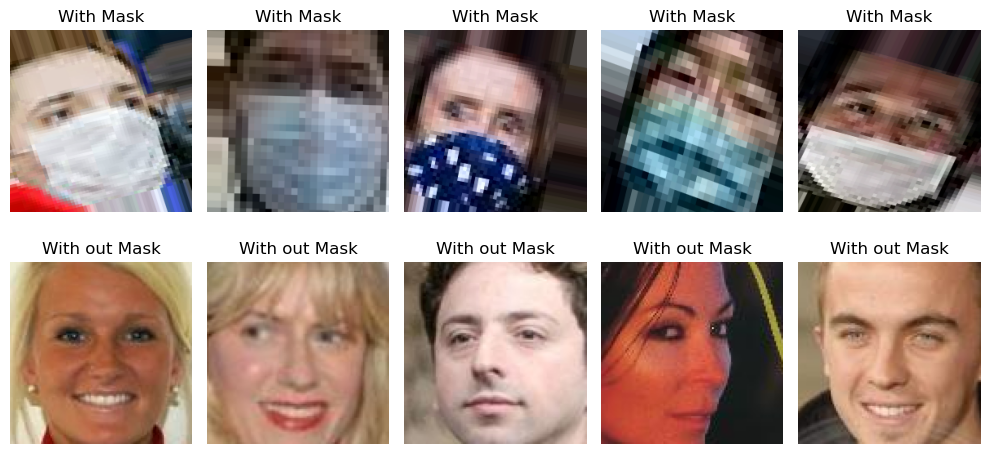

In [6]:
fig, axs = plt.subplots(2, 5, figsize=(10,5))
for i in range(5):
    axs.flat[i].imshow(plt.imread( df.query('label == "WithMask"')['filename'].iloc[i]))
    axs.flat[i].set_title(str("With Mask"))
    axs.flat[i].axis('off')
    
for i in range(5):
    axs.flat[i+5].imshow(plt.imread( df.query('label == "WithoutMask"')['filename'].iloc[i]))
    axs.flat[i+5].set_title(str("With out Mask"))
    axs.flat[i+5].axis('off')
plt.tight_layout()
plt.show()

In [7]:
image_generator=ImageDataGenerator(rescale=1/255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
image_generator=ImageDataGenerator(rescale=1/255)

In [8]:
Training = image_generator.flow_from_directory('../input/face-mask-12k-images-dataset/Face Mask Dataset/Train',target_size=(128,128),
                                            batch_size=32,class_mode='binary')

Validation = image_generator.flow_from_directory('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation' , target_size=(128,128),
                                            batch_size=32,class_mode='binary')

Test = image_generator.flow_from_directory('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test' ,target_size=(128,128),
                                            batch_size=32,class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [9]:
df['label'].value_counts(ascending=True)

WithMask       5883
WithoutMask    5909
Name: label, dtype: int64

In [10]:
print(Training.class_indices)
print(Test.class_indices)
print(Validation.class_indices)

{'WithMask': 0, 'WithoutMask': 1}
{'WithMask': 0, 'WithoutMask': 1}
{'WithMask': 0, 'WithoutMask': 1}


In [11]:
input_shape = (128,128,3)

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = input_shape))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))


model.add(Conv2D(filters =128 , kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.4))

model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))



model.add(Flatten())
#model.add(Dense(1024))
model.add(Dense(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       7

In [13]:
model.compile(optimizer = 'Adam' , loss = "binary_crossentropy", metrics=["accuracy"])

In [14]:
train_step=Training.n//Training.batch_size
test_step=Test.n//Test.batch_size
valid_step =Validation.n//Validation.batch_size

num_epochs = 15

history = model.fit_generator(Training,
                                      steps_per_epoch=train_step,
                                      epochs=num_epochs, 
                                      validation_data=Validation,
                                      validation_steps=valid_step) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/15


2023-04-20 11:03:21.959149: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


312/312 [==============================] - 95s 281ms/step - loss: 0.2022 - accuracy: 0.9180 - val_loss: 0.1035 - val_accuracy: 0.9712
Epoch 2/15
312/312 [==============================] - 21s 67ms/step - loss: 0.0988 - accuracy: 0.9688 - val_loss: 0.0649 - val_accuracy: 0.9762
Epoch 3/15
312/312 [==============================] - 21s 68ms/step - loss: 0.0649 - accuracy: 0.9785 - val_loss: 0.0375 - val_accuracy: 0.9887
Epoch 4/15
312/312 [==============================] - 22s 69ms/step - loss: 0.0457 - accuracy: 0.9854 - val_loss: 0.0380 - val_accuracy: 0.9887
Epoch 5/15
312/312 [==============================] - 21s 68ms/step - loss: 0.0347 - accuracy: 0.9890 - val_loss: 0.0186 - val_accuracy: 0.9925
Epoch 6/15
312/312 [==============================] - 22s 70ms/step - loss: 0.0304 - accuracy: 0.9888 - val_loss: 0.0369 - val_accuracy: 0.9875
Epoch 7/15
312/312 [==============================] - 22s 69ms/step - loss: 0.0353 - accuracy: 0.9883 - val_loss: 0.0315 - val_accuracy: 0.9925
Ep

In [15]:
score = model.evaluate(Test)
print(score)

31/31 [==============================] - 8s 252ms/step - loss: 0.0274 - accuracy: 0.9889
[0.027439281344413757, 0.9889112710952759]


In [16]:
Test.labels[:5]

array([0, 0, 0, 0, 0], dtype=int32)

In [17]:
print(Test.filepaths[500])
print('--------------------------------------')
print(Test.classes[500])

../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask/1202.png
--------------------------------------
1


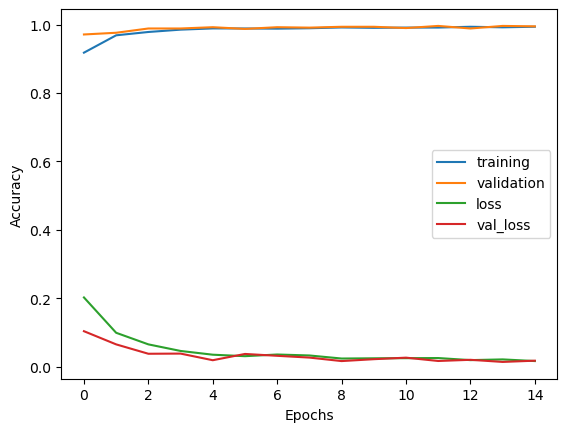

In [18]:
plt.plot(history.history['accuracy'],label='training')
plt.plot(history.history['val_accuracy'],label='validation')
plt.plot(history.history["loss"],label='loss')
plt.plot(history.history["val_loss"],label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

(128, 128, 3)
(1, 128, 128, 3)
1/1 [==============================] - 0s 157ms/step
[[1.]]
Text(0.5, 1.0, 'Without Mask')


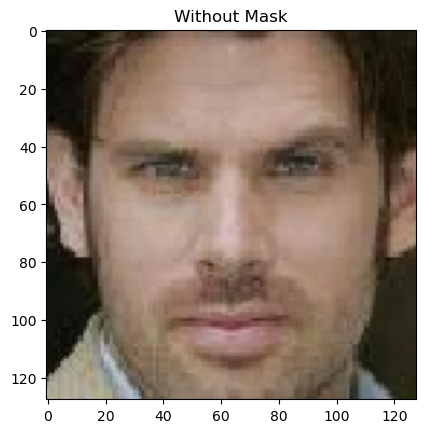

In [19]:
test_image=image.load_img('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask/1202.png',
                 target_size=(128,128))
plt.imshow(test_image)

# Convert image to array
test_image=image.img_to_array(test_image)
print(test_image.shape)

# model input is in the from of 4D (batch_size,row,column,channel=3 for 'rgb')
test_image=test_image.reshape(1,128,128,3)
print(test_image.shape)

# Making a prediction
result=model.predict(test_image)
print(result)

if result[0][0]<0.5:
    print(plt.title('With Mask'))
else:
    print(plt.title('Without Mask'))

(128, 128, 3)
(1, 128, 128, 3)
1/1 [==============================] - 0s 19ms/step
[[0.]]
Text(0.5, 1.0, 'With Mask')


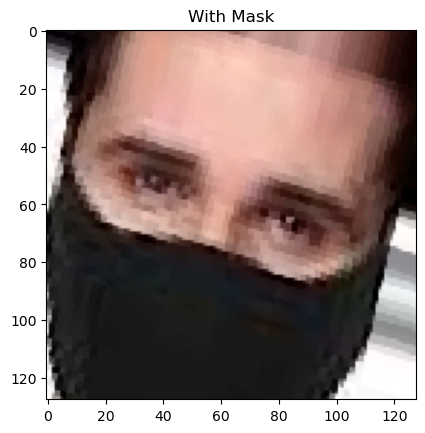

In [20]:
test_image=image.load_img('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/Augmented_738_7833036.png',
                 target_size=(128,128))
plt.imshow(test_image)

# Convert image to array
test_image=image.img_to_array(test_image)
print(test_image.shape)

# model input is in the from of 4D (batch_size,row,column,channel=3 for 'rgb')
test_image=test_image.reshape(1,128,128,3)
print(test_image.shape)

# Making a prediction
result=model.predict(test_image)
print(result)

if result[0][0]<0.5:
    print(plt.title('With Mask'))
else:
    print(plt.title('Without Mask'))
